# exp14

kmeansの距離を特徴量に加える

https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import joblib
import random
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from itertools import combinations
from sklearn.linear_model import LogisticRegression

#ランダムフォレストでImportanceの計算
from sklearn.ensemble import RandomForestClassifier

import ipywidgets as widgets
import snappy

from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pickle
from sklearn.cluster import KMeans


from pytorch_tabnet.pretraining import TabNetPretrainer

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from pytorch_tabnet.metrics import Metric
# from ipywidgets import interact, Select


# Training & Inference

In [2]:

# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp14_kmeans/'
    seed = 46
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "kmeans"
    ver = "exp14"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# XGB train
# ====================================================

def cat_train(x, y, xt, yt,cat_features):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    
    prams = {
        'depth': 8,
        'iterations':5000,
#         'learning_rate': 0.05,
        'random_state':CFG.seed,
    }

#     watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    watchlist = [(x, 'train'), (xt, 'eval')]
    clf = CatBoostClassifier(**prams)# 5000
    clf.fit(x, y, eval_set=[(xt, yt)], cat_features=cat_features,plot=True, verbose_eval = 100)
#     print('best ntree_limit:', clf.best_ntree_limit)
#     print('best score:', clf.best_score)
    # return clf.predict_proba(xt)[:, 1]
    return clf.predict_proba(xt)[:, 1], clf

def tabnet_train(x, y, xt, yt,cat_features):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    
    prams = {
        'depth': 8,
        'iterations':5000,
#         'learning_rate': 0.05,
        'random_state':CFG.seed,
    }

#     watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    watchlist = [(x, 'train'), (xt, 'eval')]
    clf = CatBoostClassifier(**prams)# 5000
    clf.fit(x, y, eval_set=[(xt, yt)], cat_features=cat_features,plot=True, verbose_eval = 100)
#     print('best ntree_limit:', clf.best_ntree_limit)
#     print('best score:', clf.best_score)
    # return clf.predict_proba(xt)[:, 1]
    return clf.predict_proba(xt)[:, 1], clf



# using amex metric to evaluate tabnet
class Amex_tabnet(Metric):
    
    def __init__(self):
        self._name = 'amex_tabnet'
        self._maximize = True

    def __call__(self, y_true, y_pred):
        amex = amex_metric_numpy(y_true, y_pred[:, 1])
        return max(amex, 0.)

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)


def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


# Created by https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [10]:
seed_everything(CFG.seed)
train, test = read_data()


In [14]:
train.shape

NameError: name 'train' is not defined

In [12]:
test.shape

(924621, 1461)

In [13]:
train["train_test"] = "train"
test["train_test"] = "test"
test["target"] = 99



df = pd.concat([train,test],axis = 0)
# df.shape

del test,train
gc.collect

<function gc.collect(generation=2)>

## kmeans
### preprocessing

In [15]:
features = [col for col in df.columns if col not in ['customer_ID', CFG.target,'train_test']]


# df_base に必要なデータのみを載せる
df_base = df[["customer_ID","train_test"]]

# all_data = features.extend("customer_ID")


df.fillna(value=0, inplace=True)
# test.fillna(value=0, inplace=True)

# ## infを含むデータを外れ値（1000000000）に置換
df = df.replace([np.inf, -np.inf],1000000000)
# test = test.replace([np.inf, -np.inf],1000000000)
print("start fitting")
sc = StandardScaler()

df = sc.fit_transform(df[features])
# test = sc.fit_transform(test[features])


start fitting


# k = 3

In [16]:

# 事前実験で２～３がよさそうだったのでとりあえず３

i = 3
km = KMeans(n_clusters=i,
            init='k-means++',     # k-means++法によりクラスタ中心を選択
            n_init=10,
            max_iter=300,
            random_state=0)

print(f"cluster start fit")
km.fit(df)

cluster start fit


KMeans(n_clusters=3, random_state=0)

In [18]:
# 属するクラスタ
pred_cluster3 = km.predict(df)

# クラスタの中心までの距離
pred_dist3 = km.transform(df)

# k = 2

In [19]:
i = 2
km = KMeans(n_clusters=i,
            init='k-means++',     # k-means++法によりクラスタ中心を選択
            n_init=10,
            max_iter=300,
            random_state=0)

print(f"cluster start fit")
km.fit(df)

cluster start fit


KMeans(n_clusters=2, random_state=0)

In [20]:
# 属するクラスタ
pred_cluster2 = km.predict(df)

# クラスタの中心までの距離
pred_dist2 = km.transform(df)

# k = 4

In [21]:
i = 4
km = KMeans(n_clusters=i,
            init='k-means++',     # k-means++法によりクラスタ中心を選択
            n_init=10,
            max_iter=300,
            random_state=0)

print(f"cluster start fit")
km.fit(df)

cluster start fit


KMeans(n_clusters=4, random_state=0)

In [22]:
# 属するクラスタ
pred_cluster4 = km.predict(df)

# クラスタの中心までの距離
pred_dist4 = km.transform(df)

# DataFrame化

In [25]:
# DataFrame化
df_base["kmeans pred 2"] = pred_cluster2
# df_base["kmeans dist 2"] = pred_dist2
df_base["kmeans pred 3"] = pred_cluster3
# df_base["kmeans dist 3"] = pred_dist3
df_base["kmeans pred 4"] = pred_cluster4
# df_base["kmeans dist 4"] = pred_dist4

In [26]:
df_base.head(30)

,customer_ID,train_test,kmeans pred 2,kmeans pred 3,kmeans pred 4
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,train,0,1,3
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,train,0,1,3
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,train,0,1,3
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,train,0,1,3
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,train,0,1,3
5,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,train,0,1,3
6,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,train,0,2,1
7,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,train,0,1,3
8,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,train,1,0,2
9,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,train,1,0,2


In [39]:
df_base["k=2 dist0"] = pred_dist2[:,0]
df_base["k=2 dist1"] = pred_dist2[:,1]

df_base["k=3 dist0"] = pred_dist3[:,0]
df_base["k=3 dist1"] = pred_dist3[:,1]
df_base["k=3 dist2"] = pred_dist3[:,2]

df_base["k=4 dist0"] = pred_dist4[:,0]
df_base["k=4 dist1"] = pred_dist4[:,1]
df_base["k=4 dist2"] = pred_dist4[:,2]
df_base["k=4 dist3"] = pred_dist4[:,3]

# df_base["kmeans dist 4"] = pred_dist4
# df_base["kmeans dist 4"] = pred_dist4
# df_base["kmeans dist 4"] = pred_dist4

In [40]:
df_base.head(30)

,customer_ID,train_test,kmeans pred 2,kmeans pred 3,kmeans pred 4,k=2 dist0,k=2 dist1,k=3 dist0,k=3 dist1,k=3 dist2,k=4 dist0,k=4 dist1,k=4 dist2,k=4 dist3
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,train,0,1,3,25.166624,34.477343,34.591785,24.542314,37.013772,46.257242,36.928858,33.000622,24.459285
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,train,0,1,3,27.286253,35.518788,36.056498,27.196349,35.689595,47.036988,35.597209,34.644702,27.113723
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,train,0,1,3,14.235463,26.757631,27.480215,14.284787,26.460009,40.664312,26.321174,25.681682,14.112861
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,train,0,1,3,19.443364,27.875988,28.549752,19.429476,28.823030,41.361567,28.726306,26.862877,19.430258
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,train,0,1,3,22.605973,29.162919,29.474405,22.350435,32.088849,41.696722,32.031077,28.017431,22.377077
5,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,train,0,1,3,16.687629,27.766021,28.406868,16.613260,28.117085,41.488663,27.990567,26.600745,16.515852
6,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,train,0,2,1,24.761642,25.633931,27.708441,25.857782,21.686022,39.445862,21.667965,26.500786,26.049793
7,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,train,0,1,3,23.193254,29.938795,30.184494,22.963947,32.711439,42.760615,32.639337,28.563384,23.013216
8,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,train,1,0,2,46.874512,39.026848,38.320993,47.006602,47.756562,47.809585,47.805082,38.180840,47.288730
9,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,train,1,0,2,38.984047,35.247145,35.442873,39.101188,40.655764,37.291759,40.877844,36.616744,39.232374


In [42]:
train = df_base[df_base["train_test"] == "train"].drop("train_test",axis = 1)
test = df_base[df_base["train_test"] == "test"].drop("train_test",axis = 1)

In [44]:
test.head()

,customer_ID,kmeans pred 2,kmeans pred 3,kmeans pred 4,k=2 dist0,k=2 dist1,k=3 dist0,k=3 dist1,k=3 dist2,k=4 dist0,k=4 dist1,k=4 dist2,k=4 dist3
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0,2,1,32.463425,35.829046,37.835909,33.790549,27.751976,47.331360,27.637196,36.820416,33.836287
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0,1,3,14.978082,26.739823,27.408044,14.829200,27.274625,40.800024,27.152812,25.531432,14.720085
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0,1,3,22.058313,27.190734,27.829080,22.062020,29.512097,40.143246,29.474249,26.397987,22.163741
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,1,0,2,31.986364,26.480544,25.750213,31.967846,36.086606,38.622284,36.110469,24.912326,32.312073
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1,0,2,34.685908,27.967206,27.824426,34.927782,35.807465,38.453583,35.887810,27.653534,35.202410


In [46]:
train.to_pickle(f"{CFG.output_dir}kmeans_feature_train.pkl")
train.to_pickle(f"{CFG.output_dir}kmeans_feature_test.pkl")

# クラスタ数の確認

1 cluster start fit
2 cluster start fit
3 cluster start fit
4 cluster start fit
5 cluster start fit
6 cluster start fit
7 cluster start fit
8 cluster start fit
9 cluster start fit
10 cluster start fit


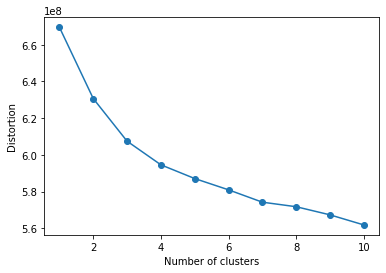

In [8]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    print(f"{i} cluster start fit")
    km.fit(train)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()